this notebook is for the capstone assignement

In [1]:
import numpy as np
import pandas as pd

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


<span style="color:blue">
below block is used to read in csv file "Collisions.csv" as pd dataframe
</span>

In [29]:
# The code was removed by Watson Studio for sharing.

csv imported


In [4]:
# make a function to check missing data
def check_missing_data(df_name):
    missing_data=df_name.isnull()

    for column in missing_data.columns.values.tolist():
        print(column)
        print (missing_data[column].value_counts())
        print("")   

# check missing data in the original list
check_missing_data(df)

X
False    213675
True       7469
Name: X, dtype: int64

Y
False    213675
True       7469
Name: Y, dtype: int64

OBJECTID
False    221144
Name: OBJECTID, dtype: int64

INCKEY
False    221144
Name: INCKEY, dtype: int64

COLDETKEY
False    221144
Name: COLDETKEY, dtype: int64

REPORTNO
False    221144
Name: REPORTNO, dtype: int64

STATUS
False    221144
Name: STATUS, dtype: int64

ADDRTYPE
False    217432
True       3712
Name: ADDRTYPE, dtype: int64

INTKEY
True     149370
False     71774
Name: INTKEY, dtype: int64

LOCATION
False    216558
True       4586
Name: LOCATION, dtype: int64

EXCEPTRSNCODE
True     120403
False    100741
Name: EXCEPTRSNCODE, dtype: int64

EXCEPTRSNDESC
True     209373
False     11771
Name: EXCEPTRSNDESC, dtype: int64

SEVERITYCODE
False    221143
True          1
Name: SEVERITYCODE, dtype: int64

SEVERITYDESC
False    221144
Name: SEVERITYDESC, dtype: int64

COLLISIONTYPE
False    194740
True      26404
Name: COLLISIONTYPE, dtype: int64

PERSONCOUNT
False    22

<span style="color:blue">
as above, we can see that data are missing in different columns, but some columns can be droppped directly based on what they are  
  
now start data cleaning  
</span>

In [30]:
# copy df to df_clean
df_clean=df.copy()

# drop code=0 and STATUS=Unmatched
drop_index=df_clean[df_clean.SEVERITYCODE=='0'].index
df_clean.drop(drop_index, inplace=True)

drop_index=df_clean[df_clean.STATUS=='Unmatched'].index
df_clean.drop(drop_index, inplace=True)

In [31]:
# drop unnecessary columns

df_clean.drop(['X','Y','OBJECTID','INCKEY','COLDETKEY','REPORTNO','STATUS','INTKEY','LOCATION','EXCEPTRSNCODE','EXCEPTRSNDESC','SEVERITYDESC','INCDATE','SDOT_COLDESC','SDOTCOLNUM','ST_COLDESC','SEGLANEKEY','CROSSWALKKEY', "INJURIES", "SERIOUSINJURIES", "FATALITIES"],axis=1,inplace=True)
df_clean.head(1)

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR
2,Block,1,Left Turn,2,0,0,2,4/2/2013 3:10:00 PM,Mid-Block (not related to intersection),11.0,NaN,N,Overcast,Dry,Daylight,NaN,NaN,28,N


In [32]:
# fill empty with 'N' in below columns
df_clean.fillna({'INATTENTIONIND':'N','PEDROWNOTGRNT':'N','SPEEDING':'N'},inplace=True)

# replace 'Y/N' into '1/0' in column 'UNDERINFL'
df_clean.UNDERINFL.replace(['Y','1'],1,inplace=True)
df_clean.UNDERINFL.replace(['N','0'],0,inplace=True)

In [33]:
# drop rows with empty value in any column
df_clean=df_clean.dropna()

<span style="color:blue">
datetime formating will take some time in below block, wait until it' done
</span>

In [34]:
# data standardzation
# this takes some time

# convert datetime format
df_clean['DATETIME']=pd.to_datetime(df_clean.INCDTTM)
df_clean.drop(['INCDTTM'],axis=1,inplace=True)

# replace "Y/N" into "1/0"
cols=['INATTENTIONIND','PEDROWNOTGRNT','SPEEDING']
df_clean[cols]=df_clean[cols].replace('Y',1)
df_clean[cols]=df_clean[cols].replace('N',0)

print('job done!')

job done!


<span style="color:blue">
the data cleaning is almost done, let's check data balance
</span>

In [35]:
# check data balance
df_clean.SEVERITYCODE.value_counts()

1     127279
2      57162
2b      3014
3        337
Name: SEVERITYCODE, dtype: int64

<span style="color:blue">
here we can see that the data is quite inbalanced, let's first bin code-1 as Low severity cases, and High for others, so that we can take advantage of different classifer models
</span>

In [36]:
df_clean.SEVERITYCODE.replace(['1',1],'Low',inplace=True)
df_clean.SEVERITYCODE.replace(['2','2b','3',2,3],'High',inplace=True)

In [37]:
# cut the latest 30000 samples from dataset
df_clean.sort_values(by=['DATETIME'],ascending=False,inplace=True)
df_clean=df_clean[0:30000]
df_clean.reset_index(inplace=True)
df_clean.drop('index',axis=1, inplace=True)

In [39]:
df_clean.SEVERITYCODE.value_counts()

Low     19516
High    10484
Name: SEVERITYCODE, dtype: int64

In [40]:
# ramdonly select 10000 samples from each category
df_low=df_clean[df_clean.SEVERITYCODE=='Low']
df_high=df_clean[df_clean.SEVERITYCODE=='High']
low_index=np.random.choice(df_low.index,size=10000)
high_index=np.random.choice(df_high.index,size=10000)

df_clean=pd.concat([df_clean.iloc[low_index],df_clean.iloc[high_index]])

In [41]:
# exam
df_clean.SEVERITYCODE.value_counts()

Low     10000
High    10000
Name: SEVERITYCODE, dtype: int64

<span style="color:blue">
here we end up with 20000 samples and 18 potential features  
    
more analysis will be done in below sections to prepare features in suitable forms for modeling
</span>

In [42]:
import seaborn as sns
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

<span style="color:blue">
in the following blocks, each column will be analized and converted if necessary  
  
and it will be easier if we separate low severity and high severity data
</span>

In [43]:
df_low=df_clean[df_clean.SEVERITYCODE=='Low']
df_high=df_clean[df_clean.SEVERITYCODE=='High']

<span style="color:blue">
let's define a bar chart function to plot out each column against severity
</span>

In [44]:
def bar_chart(cloumn_name):
    plot_low=pd.DataFrame(df_low[cloumn_name].value_counts())
    plot_low.rename(columns={cloumn_name:'Low'},inplace=True)
    plot_high=pd.DataFrame(df_high[cloumn_name].value_counts())
    plot_high.rename(columns={cloumn_name:'High'},inplace=True)
    df_plot=plot_low.join(plot_high,how='outer')
    df_plot.fillna(0)
    ax=df_plot.plot(kind='bar',figsize=(10, 5),color=['#5cb85c','#d9534f'])
    ax.set_title(cloumn_name,size=10)

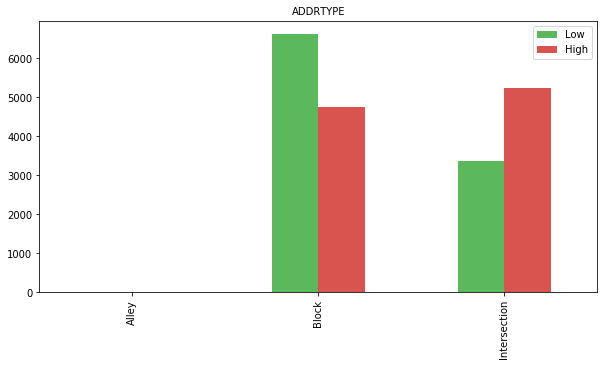

In [45]:
bar_chart('ADDRTYPE')

<span style="color:blue">
we can find that when the accident is happened at a "Block", it has a higher probability to have a lower severity. the reason could be that the traffic condition there is usuall less complicated than at an intersection.  
      
we can also notic that "Alley" has few/no sample, and after investigate in the original list, there are indeed too few samples. and since it has a similar pattern as "Block" (more Low's than High's), let bin them together.
</span>

In [46]:
# use 0 to represent block and alley, 1 for intersection
df_clean.ADDRTYPE.replace(['Block','Alley'],0,inplace=True)
df_clean.ADDRTYPE.replace('Intersection',1,inplace=True)

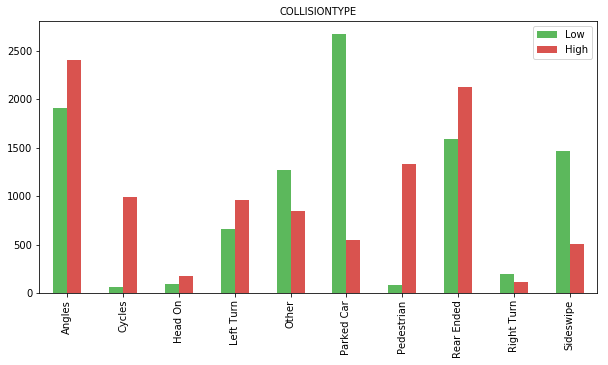

In [47]:
bar_chart('COLLISIONTYPE')

<span style="color:blue">
this chart shows that when hitting into a parked car, or if just a sideswipe, it's usually a low severity  
    
but if it involves cycles or pedestrians, very likely it'll be a high severity since someone is probably injured.  
or if two cars are hit at an angle or rear ended, the severity also tends to be high, since the cars are usually paralized in such collision.
</span>

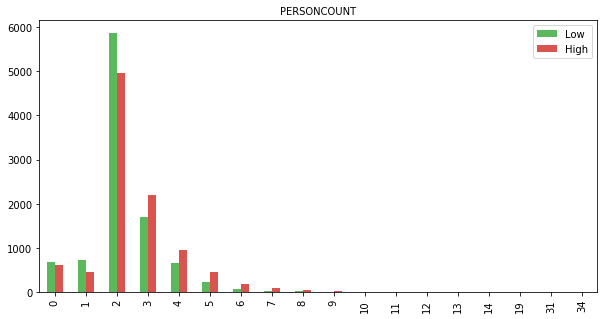

In [48]:
bar_chart('PERSONCOUNT')

<span style="color:blue">
as the number of involved people increases, it's more likely to have a higher severity  
    
since this is a numeric value, let's just leave it be. but easy to see that cases with more than 10 involved people are very few, let's bin them into 10
</span>

In [49]:
# bin (>=10)
df_clean.PERSONCOUNT.replace(list(range(10,50)),10,inplace=True)

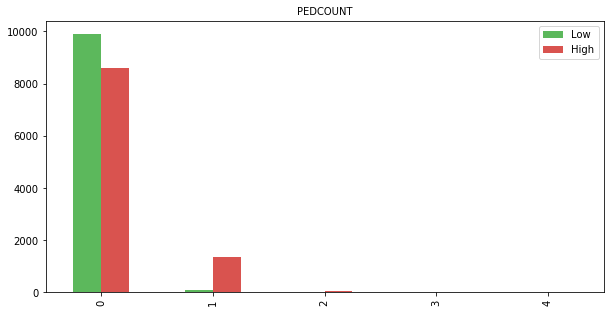

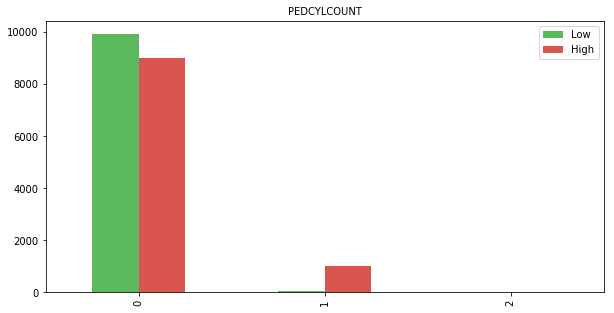

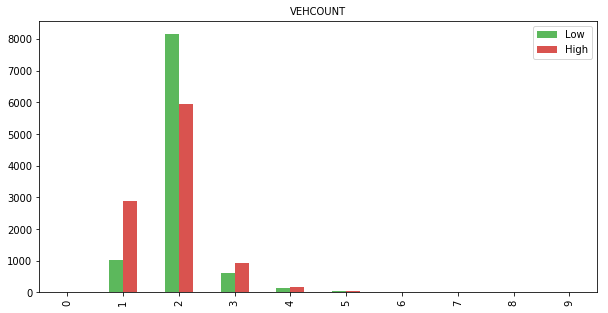

In [50]:
bar_chart('PEDCOUNT')
bar_chart('PEDCYLCOUNT')
bar_chart('VEHCOUNT')

<span style="color:blue">
the findings from above three charts are corelated, and are also reflected by the "COLLISIONTYPE", where we've already found out that when cycles or pedestrians are involved, usually it will have a high severity. that's the reason why the pattens are opposite between 0 and 1 for "PEDCOUNT" and "PEDCYLCOUNT"
    
and it also explains why a single vehcile accident is more likely to have a high severity, because in those cases, the car probably hit cycles or pedestrians.  
    
we can condsider to drop these three columns since they have already been covered by "COLLISIONTYPE", and "COLLISIONTYPE" tends to be a more explicit indicator.
</span>

In [51]:
# drop columns
df_clean.drop(['PEDCOUNT','PEDCYLCOUNT','VEHCOUNT'],axis=1,inplace=True)

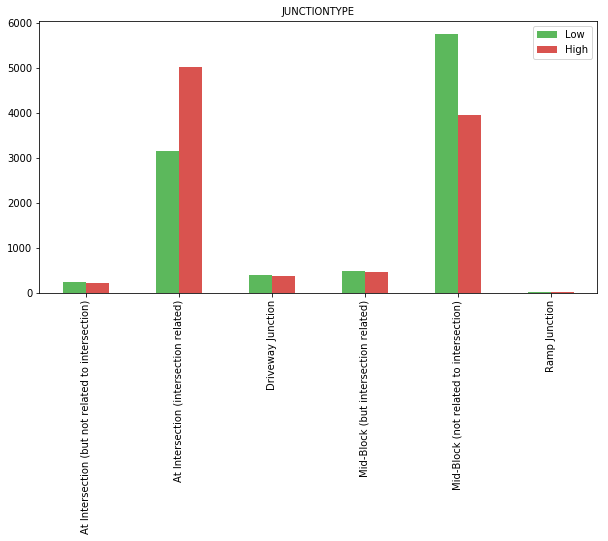

In [52]:
bar_chart('JUNCTIONTYPE')

<span style="color:blue">
if we recall the findings from the first chart "ADDRTYPE", we can find out that they just reinforce to each other, so that we can consider to drop this column.
</span>

In [53]:
# drop columns
df_clean.drop('JUNCTIONTYPE',axis=1,inplace=True)

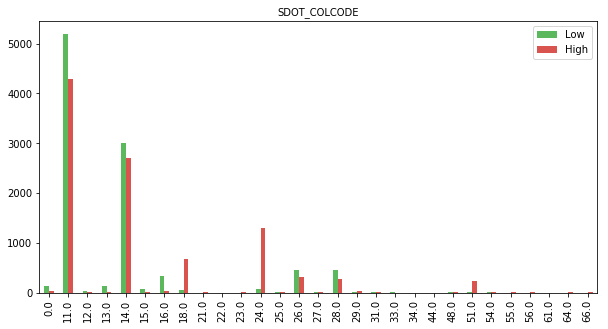

In [54]:
bar_chart('SDOT_COLCODE')

<span style="color:blue">
let's pick out the code's with most cases, which are 11,14,16,18,24,26,28,51, and check their description as below:  
</span>
  
11	MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE  
14	MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END  
16	MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE  
18	MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE  
24	MOTOR VEHCILE STRUCK PEDESTRIAN  
26	MOTOR VEHICLE STRUCK OBJECT IN ROAD  
28	MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT  
51	PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE  
  
<span style="color:blue">
well, based on the description,we can notice that code-11 in this chart seems to be contradictary to "COLLISIONTYPE", where we've found out that "Angle" should have a high severity. but if look closely, we'll find that code-18 and code-51 should also be counted in as "Angle", so that the number of cases are actully quite balanced. and code-16, code-18, code-24 can also reinforce the findings from "COLLISIONTYPE", so that we can consider to drop this column as it's already coverd.
</span>



In [55]:
# drop columns
df_clean.drop('SDOT_COLCODE',axis=1,inplace=True)

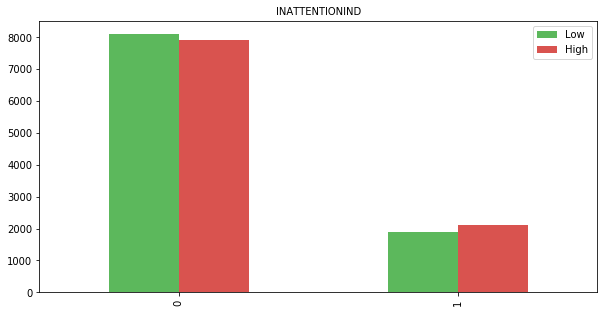

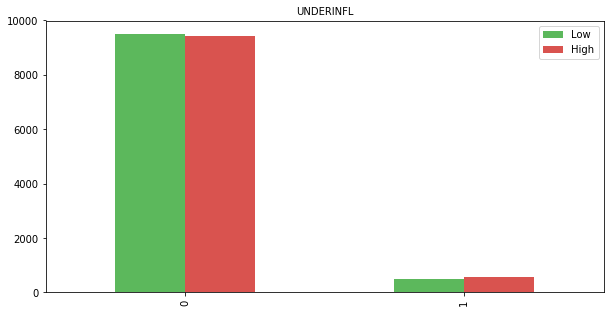

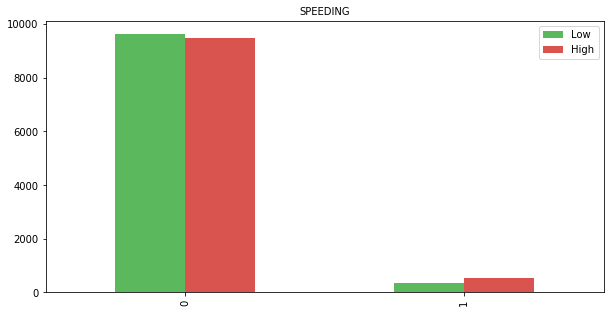

In [56]:
bar_chart('INATTENTIONIND')
bar_chart('UNDERINFL')
bar_chart('SPEEDING')

<span style="color:blue">
so that we can see if an accident is due to the driver's subjective mistake (inattention, under influence of drug/alcohol, or speeding), more likely it ill have a high severity.  
    
we can try to merge these three columns into one, and call it "MISTAKE", and use the sum of the values to represent the degree of mistake, ranging from 0 to 3.
</span>

In [57]:
df_clean['MISTAKE']=df_clean.INATTENTIONIND+df_clean.UNDERINFL+df_clean.SPEEDING
df_clean.drop(['INATTENTIONIND','UNDERINFL','SPEEDING'],axis=1,inplace=True)
df_clean.groupby(df_clean.SEVERITYCODE).MISTAKE.value_counts()

SEVERITYCODE  MISTAKE
High          0          7014
              1          2768
              2           211
              3             7
Low           0          7396
              1          2472
              2           130
              3             2
Name: MISTAKE, dtype: int64

<span style="color:blue">
OK, it looks like we can just bin them into 0 and 1, let's do it
</span>

In [58]:
df_clean.MISTAKE.replace([1,2,3],1,inplace=True)

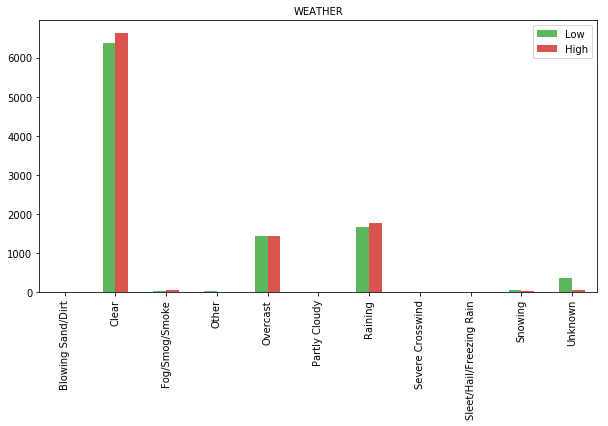

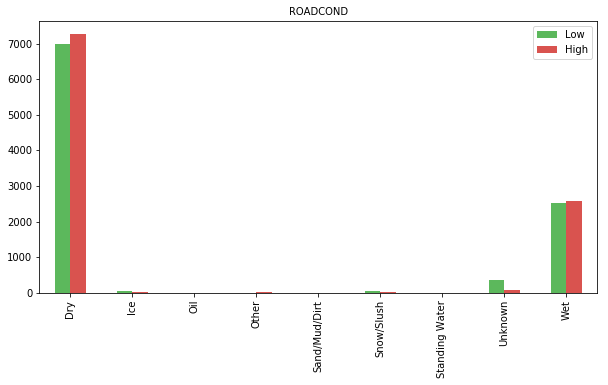

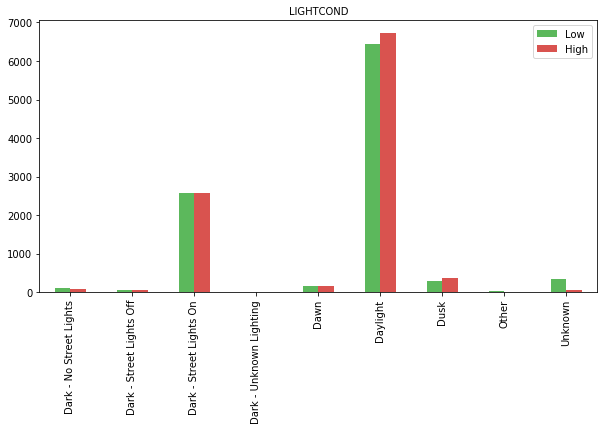

In [59]:
bar_chart('WEATHER')
bar_chart('ROADCOND')
bar_chart('LIGHTCOND')

<span style="color:blue">
well, it seems these feaures don't tell much about the severity of an accident, I have to admit it is not expected, that even in a raining day where the number of low severity cases and high severity are still balanced. instead, we have slightly more high severity cases in a clear day, during daytime, or on a dry road. but the numbers are actually quite even.  
    
since these features are not so informative, let's just drop them
</span>

In [60]:
# drop columns
df_clean.drop(['WEATHER','ROADCOND','LIGHTCOND'],axis=1,inplace=True)

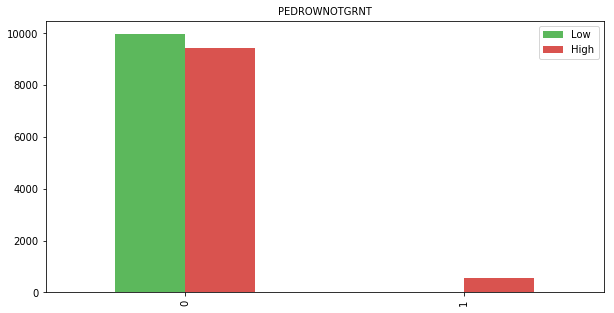

In [61]:
bar_chart('PEDROWNOTGRNT')

<span style="color:blue">
obviously, if the pedestrain is walking in the wrong place, the cases usually have a high severity. 
</span>

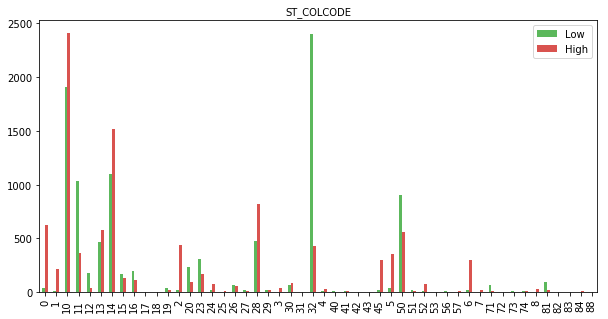

In [62]:
bar_chart('ST_COLCODE')

<span style="color:blue">
by reading the file "Metadata", we'll see that the result shown here, just reflects the findings in "COLLISIONTYPE", but is broken down into more detailed categories. let's drop it.
</span>

In [63]:
# drop columns
df_clean.drop('ST_COLCODE',axis=1,inplace=True)

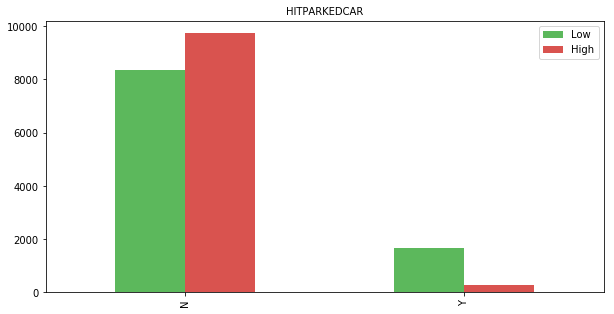

In [64]:
bar_chart('HITPARKEDCAR')

<span style="color:blue">
this is also a sub-feature of "COLLISIONTYPE", whether a parked car is hit, let's drop it.
</span>

In [65]:
# drop columns
df_clean.drop('HITPARKEDCAR',axis=1,inplace=True)

In [66]:
df_clean.reset_index(inplace=True)
df_clean.drop('index',axis=1,inplace=True)
df_clean.head()

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDROWNOTGRNT,DATETIME,MISTAKE
0,1,Low,Other,1,0,2019-10-20 23:53:00,0
1,0,Low,Parked Car,2,0,2019-06-28 18:00:00,0
2,0,Low,Parked Car,2,0,2019-05-01 13:48:00,1
3,0,Low,Parked Car,3,0,2019-07-06 12:45:00,1
4,0,Low,Parked Car,2,0,2019-03-05 18:00:00,0


<span style="color:blue">
now let's convert "COLLISIONTYPE" into one-hot features.
</span>

In [67]:
# construct dataframe
column_type=df_clean.COLLISIONTYPE.unique()

for items in column_type:
    df_clean[items]=np.zeros(20000)

In [68]:
# fill in one-hot values and drop the old column
for item in column_type:
    index_id=df_clean[df_clean.COLLISIONTYPE==item].index
    df_clean[item].iloc[index_id]=1

df_clean.drop('COLLISIONTYPE',axis=1,inplace=True)
df_clean.head(1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,ADDRTYPE,SEVERITYCODE,PERSONCOUNT,PEDROWNOTGRNT,DATETIME,MISTAKE,Other,Parked Car,Rear Ended,Sideswipe,Angles,Head On,Right Turn,Left Turn,Pedestrian,Cycles
0,1,Low,1,0,2019-10-20 23:53:00,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<span style="color:blue">
we still have datetime in the list, let's see if this is a valuable feature  
    
but working on the entile list consumes too much time, let's just check 2018
</span>

In [344]:
# prepare list of 2018
df_exam=df_clean[(df_clean.DATETIME>pd.Timestamp('2019-01-01T00'))&(df_clean.DATETIME<pd.Timestamp('2020-01-01T00'))].copy()

In [345]:
# separate into month,weekday and hour
df_exam['Month']=np.zeros(len(df_exam))
df_exam['Weekday']=np.zeros(len(df_exam))
df_exam['Hour']=np.zeros(len(df_exam))

df_exam.head(1)

,ADDRTYPE,SEVERITYCODE,PERSONCOUNT,INJURIES,PEDROWNOTGRNT,DATETIME,MISTAKE,Sideswipe,Other,Angles,Left Turn,Parked Car,Rear Ended,Cycles,Pedestrian,Right Turn,Head On,Month,Weekday,Hour
0,0,Low,2,0,0,2019-11-12 19:08:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<span style="color:blue">
below block wil need to take several minutes, wait until job done!
</span>

In [283]:
# fill in columns, time consuming!
for i in range(len(df_exam)):
    df_exam['Month'].iloc[i]=df_exam.DATETIME.iloc[i].month
    df_exam['Weekday'].iloc[i]=df_exam.DATETIME.iloc[i].dayofweek
    df_exam['Hour'].iloc[i]=df_exam.DATETIME.iloc[i].hour
print('job done')

job done


In [284]:
# let's do bining and analysis
# bin month into seasons
df_exam.Month.replace([12,1,2],'Winter',inplace=True)
df_exam.Month.replace([3,4,5],'Spring',inplace=True)
df_exam.Month.replace([6,7,8],'Summer',inplace=True)
df_exam.Month.replace([9,10,11],'Autumn',inplace=True)

#bin weekday 
df_exam.Weekday.replace([0,1,2,3,4],'Weekdays',inplace=True)
df_exam.Weekday.replace([5,6],'Weekends',inplace=True)

# bin hours
df_exam.Hour.replace([6,7,8,9,16,17,18,19],'Peak',inplace=True)
df_exam.Hour.replace([0,1,2,3,4,5,10,11,12,13,14,15,20,21,22,23,24],'Valley',inplace=True)

In [285]:
# separate low and high
df_lowb=df_exam[df_exam.SEVERITYCODE=='Low']
df_highb=df_exam[df_exam.SEVERITYCODE=='High']

In [346]:
# check data balance
df_exam.SEVERITYCODE.value_counts()

High    2974
Low     2843
Name: SEVERITYCODE, dtype: int64

In [287]:
# lets's do a quick balancing
coef=2953/2922

In [288]:
def bar_chartb(cloumn_name):
    plot_low=pd.DataFrame(df_lowb[cloumn_name].value_counts()*coef)
    plot_low.rename(columns={cloumn_name:'Low'},inplace=True)
    plot_high=pd.DataFrame(df_highb[cloumn_name].value_counts())
    plot_high.rename(columns={cloumn_name:'High'},inplace=True)
    df_plot=plot_low.join(plot_high,how='outer')
    df_plot.fillna(0)
    ax=df_plot.plot(kind='bar',figsize=(10, 5),color=['#5cb85c','#d9534f'])
    ax.set_title(cloumn_name,size=10)

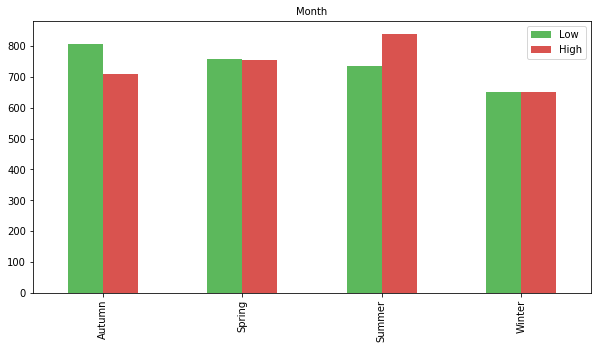

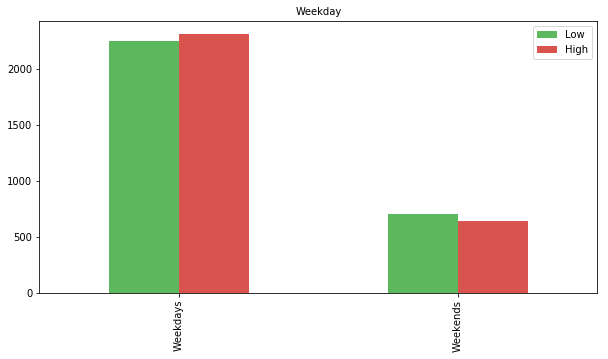

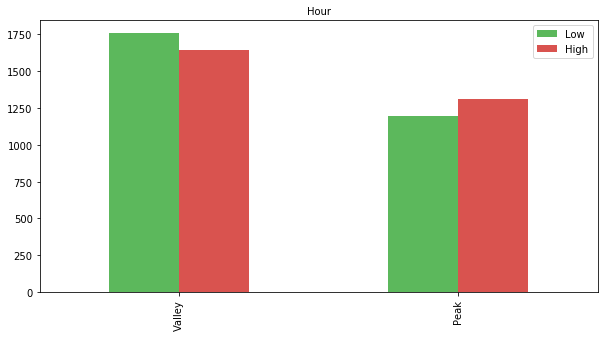

In [289]:
bar_chartb('Month')
bar_chartb('Weekday')
bar_chartb('Hour')

<span style="color:blue">
as we can see that weekdays/weekends doesn't matter, while peak/valley hours do have their own charactors.  
    
when it comes to differences between months, seems that there are less high severity cases during cold seasons.  
now we will need to work on the entile list, a time consuming job!
</span>

In [ ]:
df_clean['Month']=np.zeros(20000)
df_clean['Hour']=np.zeros(20000)

# fill in columns, time consuming!
for i in range(len(df_clean)):
    df_clean['Month'].iloc[i]=df_clean.DATETIME.iloc[i].month
    df_clean['Hour'].iloc[i]=df_clean.DATETIME.iloc[i].hour
print('job done')

In [ ]:
# bin values according to above analysis
# bin month into to parts
df_exam.Month.replace([3,4,5,6,7,8],'Warm',inplace=True)
df_exam.Month.replace([9,10,11,12,1,2],'Cold',inplace=True)

# bin hours
df_exam.Hour.replace([6,7,8,9,16,17,18,19],'Peak',inplace=True)
df_exam.Hour.replace([0,1,2,3,4,5,10,11,12,13,14,15,20,21,22,23,24],'Valley',inplace=True)